In [46]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skin-cancer-dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test/mel/ISIC_0000036.jpg
/kaggle/input/skin-cancer-dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test/mel/ISIC_0000040.jpg
/kaggle/input/skin-cancer-dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test/mel/ISIC_0000043.jpg
/kaggle/input/skin-cancer-dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test/mel/ISIC_0000013.jpg
/kaggle/input/skin-cancer-dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test/mel/ISIC_0000046.jpg
/kaggle/input/skin-cancer-dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test/mel/ISIC_0000029.jpg
/kaggle/input/skin-cancer-dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test/mel/ISIC_0000004.jpg
/kaggle/input/skin-cancer-dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test/mel/ISIC_0000054.jpg
/kaggle/input/skin-cance

##### Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

In [3]:
## Importing all Libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
data_dir_train = pathlib.Path("/kaggle/input/skin-cancer-dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/kaggle/input/skin-cancer-dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [7]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


##### This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

#### Load using keras.preprocessing
Let's load these images off disk using the helpful image_dataset_from_directory utility.

#### Create a dataset
Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

In [9]:
### Use 80% of the images for training, and 20% for validation.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size = (img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size = (img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['akice', 'bcc', 'df', 'mel', 'nv', 'pbk', 'scc', 'sk', 'vasc']


### Basically these are abbreviations for the following classes
##### ('actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion')

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

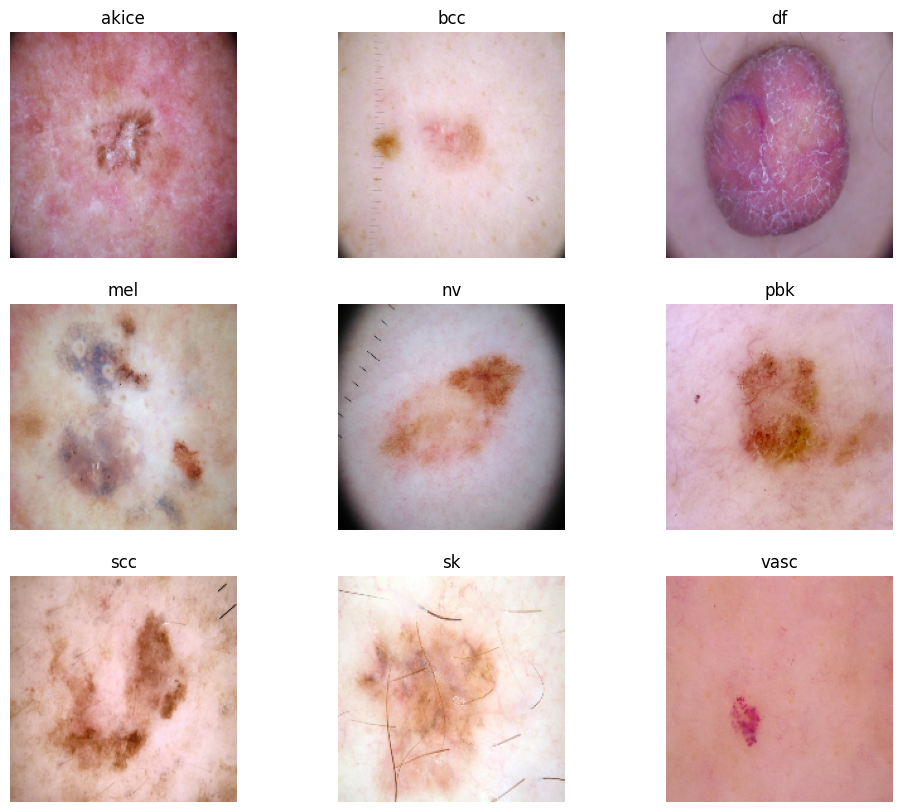

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
for i in range(len(class_names)):
  filt_ds = train_ds.filter(lambda x,l:tf.math.equal(l[0], i))
  for image, label in filt_ds.take(1):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image[0].numpy().astype('uint8'))
    plt.title(class_names[label.numpy()[0]])
    plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [52]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2

In [76]:
num_classes = len(class_names)
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(16,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 20% Fraction of the input units to drop.
model.add(layers.Dropout(0.2))

#Flatten Layer
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(num_classes,activation='softmax'))


##### Compile the model
##### Choose an appropirate optimiser and loss function for model training

In [77]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [78]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_15 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 89, 89, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 43, 43, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 41, 41, 64)      

### Train the model

In [79]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


2023-10-10 12:09:53.019877: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_18/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


56/56 [==============================] - 17s 238ms/step - loss: 2.0970 - accuracy: 0.2600 - val_loss: 1.7319 - val_accuracy: 0.3647
Epoch 2/20
56/56 [==============================] - 14s 221ms/step - loss: 1.8096 - accuracy: 0.3304 - val_loss: 2.0401 - val_accuracy: 0.2170
Epoch 3/20
56/56 [==============================] - 14s 221ms/step - loss: 1.9553 - accuracy: 0.2985 - val_loss: 1.7230 - val_accuracy: 0.4027
Epoch 4/20
56/56 [==============================] - 16s 262ms/step - loss: 1.7798 - accuracy: 0.3594 - val_loss: 1.6106 - val_accuracy: 0.4228
Epoch 5/20
56/56 [==============================] - 14s 219ms/step - loss: 1.6635 - accuracy: 0.4040 - val_loss: 1.4945 - val_accuracy: 0.4855
Epoch 6/20
56/56 [==============================] - 15s 238ms/step - loss: 1.5651 - accuracy: 0.4526 - val_loss: 1.4881 - val_accuracy: 0.4877
Epoch 7/20
56/56 [==============================] - 16s 263ms/step - loss: 1.5459 - accuracy: 0.4526 - val_loss: 1.5698 - val_accuracy: 0.4586
Epoch 8/20

### Visualizing training results

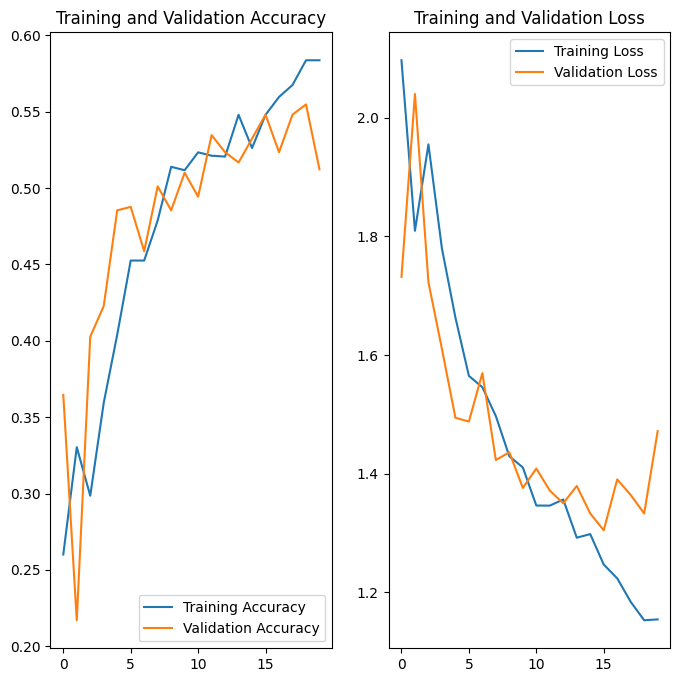

In [80]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### This show clear overfit , the train accuracy is around 59 percent however , the validation accuracy is around 51 percent

### After have analysed the model fit history for presence of of overfit, we choose an appropriate data augumentation strategy. 

In [ ]:
### Augmenting Data
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

### Visualize Augmented data

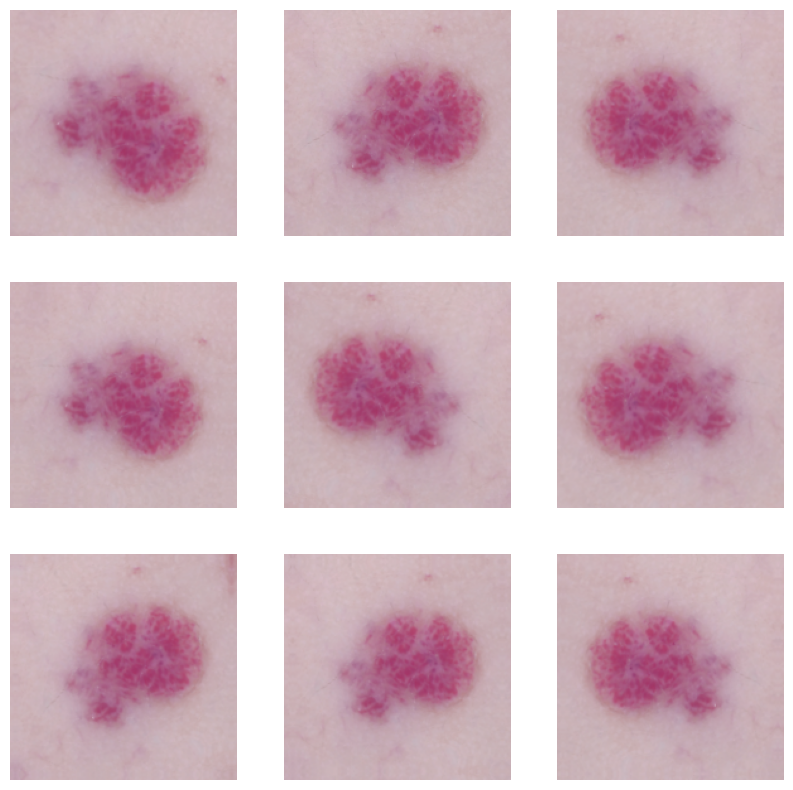

In [82]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create the model, compile and train the model

In [84]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [85]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [86]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


2023-10-10 12:23:40.213110: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_21/dropout_15/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


56/56 [==============================] - 17s 225ms/step - loss: 1.9621 - accuracy: 0.3092 - val_loss: 1.6639 - val_accuracy: 0.3758
Epoch 2/20
56/56 [==============================] - 14s 226ms/step - loss: 1.6393 - accuracy: 0.4196 - val_loss: 1.8458 - val_accuracy: 0.3512
Epoch 3/20
56/56 [==============================] - 14s 221ms/step - loss: 1.6261 - accuracy: 0.4202 - val_loss: 1.4948 - val_accuracy: 0.4855
Epoch 4/20
56/56 [==============================] - 15s 246ms/step - loss: 1.4870 - accuracy: 0.4648 - val_loss: 1.4109 - val_accuracy: 0.5145
Epoch 5/20
56/56 [==============================] - 16s 265ms/step - loss: 1.4816 - accuracy: 0.4872 - val_loss: 1.6528 - val_accuracy: 0.4049
Epoch 6/20
56/56 [==============================] - 17s 277ms/step - loss: 1.5071 - accuracy: 0.4821 - val_loss: 1.4717 - val_accuracy: 0.4944
Epoch 7/20
56/56 [==============================] - 14s 226ms/step - loss: 1.4107 - accuracy: 0.4972 - val_loss: 1.3559 - val_accuracy: 0.5190
Epoch 8/20

### Visualizing the results again

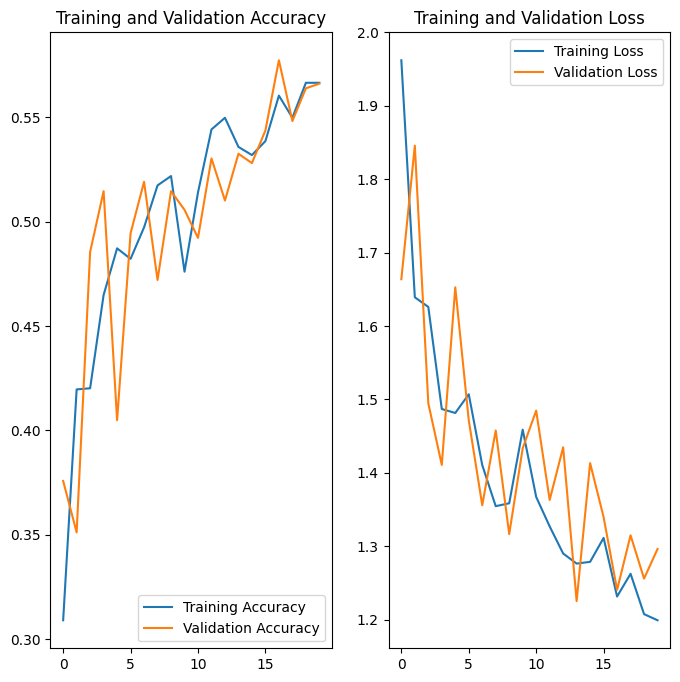

In [87]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### After data augmentation , we see that the model is better in terms of training and validation accuracy but overall the accuracy is less and the model kind of underfits. we need to improve the accuracy

#### Find the distribution of classes in the training dataset.
#### Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.¶

In [88]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict_original = dict(zip(path_list, lesion_list))
df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
df

,Path,Label
0,/kaggle/input/skin-cancer-dataset/Skin cancer ...,mel
1,/kaggle/input/skin-cancer-dataset/Skin cancer ...,mel
2,/kaggle/input/skin-cancer-dataset/Skin cancer ...,mel
3,/kaggle/input/skin-cancer-dataset/Skin cancer ...,mel
4,/kaggle/input/skin-cancer-dataset/Skin cancer ...,mel
...,...,...
2234,/kaggle/input/skin-cancer-dataset/Skin cancer ...,bcc
2235,/kaggle/input/skin-cancer-dataset/Skin cancer ...,bcc
2236,/kaggle/input/skin-cancer-dataset/Skin cancer ...,bcc
2237,/kaggle/input/skin-cancer-dataset/Skin cancer ...,bcc


Class=3, n=438 (19.562%)
Class=8, n=139 (6.208%)
Class=7, n=77 (3.439%)
Class=6, n=181 (8.084%)
Class=2, n=95 (4.243%)
Class=4, n=357 (15.945%)
Class=0, n=114 (5.092%)
Class=5, n=462 (20.634%)
Class=1, n=376 (16.793%)


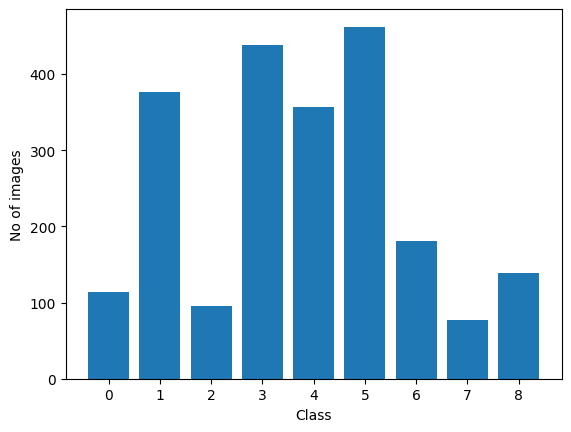

In [90]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter

X, y = df['Path'], df['Label']
y = LabelEncoder().fit_transform(y)
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

plt.bar(counter.keys(), counter.values())
plt.xticks([i for i in range(9)])
plt.xlabel("Class")
plt.ylabel("No of images")
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples - Class 7 has the least number
#### - Which classes dominate the data in terms proportionate number of samples -Class 5 has the highest number hence it is more dominant

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [28]:
import Augmentor

ModuleNotFoundError: No module named 'Augmentor'

In [29]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.

In [118]:
path_to_training_dataset = '/kaggle/input/skin-cancer-dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
import Augmentor
for i in class_names:
#     print(str(path_to_training_dataset) + "/" + i)
    p = Augmentor.Pipeline(str(path_to_training_dataset) + "/" + i, output_directory = '/kaggle/working/' + i +'/output/')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /kaggle/working/akice/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E403E101120>: 100%|██████████| 500/500 [00:12<00:00, 39.78 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to /kaggle/working/bcc/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E3FD3F5D1E0>: 100%|██████████| 500/500 [00:12<00:00, 40.28 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to /kaggle/working/df/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E3FB0464AF0>: 100%|██████████| 500/500 [00:12<00:00, 40.72 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /kaggle/working/mel/output/.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7E3FDA9CCCD0>: 100%|██████████| 500/500 [01:05<00:00,  7.67 Samples/s]                    


Initialised with 357 image(s) found.
Output directory set to /kaggle/working/nv/output/.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7E403E520250>: 100%|██████████| 500/500 [01:01<00:00,  8.15 Samples/s]                    


Initialised with 462 image(s) found.
Output directory set to /kaggle/working/pbk/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E4050CB7820>: 100%|██████████| 500/500 [00:12<00:00, 41.00 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /kaggle/working/scc/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E403E574820>: 100%|██████████| 500/500 [00:12<00:00, 41.44 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to /kaggle/working/sk/output/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E403ED29AE0>: 100%|██████████| 500/500 [00:29<00:00, 17.07 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to /kaggle/working/vasc/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E3FB0109660>: 100%|██████████| 500/500 [00:12<00:00, 39.58 Samples/s]                  


### Clearly the path is now kaggle output direcory where the augmentor has stored the images
### Lets take a count

In [119]:
output_dir = pathlib.Path('/kaggle/working/')
image_count_train = len(list(output_dir.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [120]:
path_list = [x for x in glob(os.path.join(output_dir, '*','output', '*.jpg'))]
path_list[:5]

['/kaggle/working/df/output/df_original_ISIC_0028790.jpg_edfbf7b5-9cba-41ed-9a3f-119f372f5872.jpg',
 '/kaggle/working/df/output/df_original_ISIC_0031271.jpg_52da2ec5-40ae-43ec-8f6d-078013ea299c.jpg',
 '/kaggle/working/df/output/df_original_ISIC_0032114.jpg_9e61551c-72fb-4e37-9a26-0a5f30f4e4a9.jpg',
 '/kaggle/working/df/output/df_original_ISIC_0033005.jpg_7ec9588f-dfdd-4756-8903-c3d110034972.jpg',
 '/kaggle/working/df/output/df_original_ISIC_0029248.jpg_66c1830b-277a-4416-85fb-a5c84742cd31.jpg']

In [121]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(output_dir, '*','output', '*.jpg'))]
lesion_list_new[:5]

['df', 'df', 'df', 'df', 'df']

In [122]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [123]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df._append(df2)

In [124]:
new_df['Label'].value_counts()

Label
pbk      1462
mel      1438
bcc      1376
nv       1357
scc      1181
vasc     1139
akice    1114
df       1095
sk       1077
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [102]:

batch_size = 32
img_height = 180
img_width = 180

### Create a training dataset

In [125]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9000 files belonging to 9 classes.
Using 7200 files for training.


### Create a validation dataset

In [126]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9000 files belonging to 9 classes.
Using 1800 files for validation.


In [127]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Create your model (make sure to include normalization

In [130]:
num_classes = len(class_names)
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_22 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_51 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 activation_26 (Activation)  (None, 180, 180, 16)      0         
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 dropout_26 (Dropout)        (None, 90, 90, 16)        0         
                                                                 
 conv2d_52 (Conv2D)          (None, 90, 90, 32)        4640      
                                                     

#### Compile the model

In [131]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Train your model

In [132]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


2023-10-10 13:52:31.429466: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_26/dropout_26/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


225/225 [==============================] - 27s 39ms/step - loss: 1.8976 - accuracy: 0.2901 - val_loss: 1.5872 - val_accuracy: 0.3861
Epoch 2/30
225/225 [==============================] - 4s 19ms/step - loss: 1.4033 - accuracy: 0.4565 - val_loss: 1.4551 - val_accuracy: 0.4606
Epoch 3/30
225/225 [==============================] - 4s 19ms/step - loss: 1.2052 - accuracy: 0.5437 - val_loss: 1.2684 - val_accuracy: 0.5428
Epoch 4/30
225/225 [==============================] - 4s 19ms/step - loss: 1.0611 - accuracy: 0.6124 - val_loss: 1.3611 - val_accuracy: 0.5478
Epoch 5/30
225/225 [==============================] - 4s 19ms/step - loss: 0.9215 - accuracy: 0.6726 - val_loss: 1.3326 - val_accuracy: 0.5356
Epoch 6/30
225/225 [==============================] - 4s 19ms/step - loss: 0.8170 - accuracy: 0.7040 - val_loss: 1.0964 - val_accuracy: 0.6383
Epoch 7/30
225/225 [==============================] - 4s 19ms/step - loss: 0.7067 - accuracy: 0.7486 - val_loss: 1.0371 - val_accuracy: 0.6700
Epoch 8/3

### Validate results

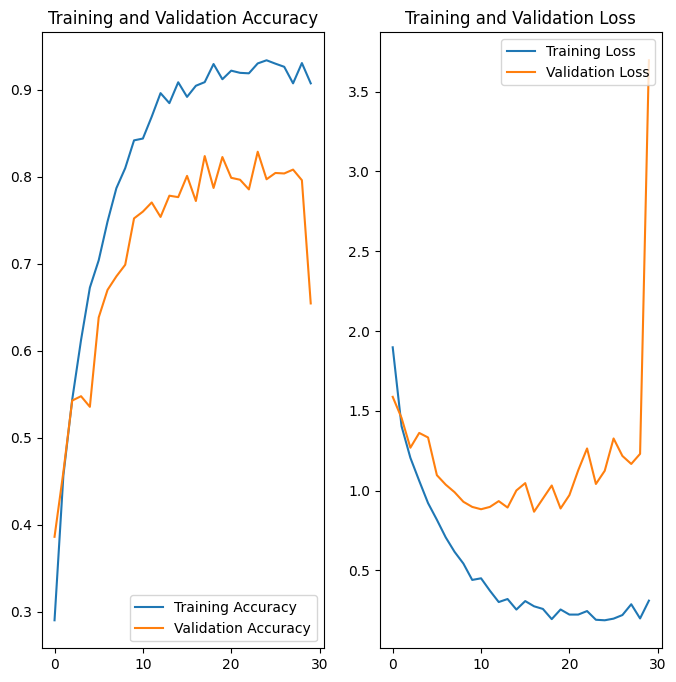

In [133]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### We have better accuracy than earler but the data is still overfitting
### we will use data augmentation to get rid of overfitting

In [137]:
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

### Model building

In [138]:
num_classes = len(class_names)
model = data_augmentation
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.20))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes))

In [141]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [142]:
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_3 (RandomFlip)  (None, 180, 180, 3)       0         
                                                                 
 random_rotation_3 (RandomRo  (None, 180, 180, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_3 (RandomZoom)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_25 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_58 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 activation_34 (Activation)  (None, 180, 180, 16)      0         
                                                     

In [143]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


2023-10-10 14:05:30.802724: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_28/dropout_30/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


225/225 [==============================] - 7s 22ms/step - loss: 1.8398 - accuracy: 0.2847 - val_loss: 1.5261 - val_accuracy: 0.4061
Epoch 2/30
225/225 [==============================] - 5s 21ms/step - loss: 1.4576 - accuracy: 0.4338 - val_loss: 1.4195 - val_accuracy: 0.4617
Epoch 3/30
225/225 [==============================] - 5s 21ms/step - loss: 1.3703 - accuracy: 0.4726 - val_loss: 1.3534 - val_accuracy: 0.5172
Epoch 4/30
225/225 [==============================] - 5s 22ms/step - loss: 1.3005 - accuracy: 0.4944 - val_loss: 1.4336 - val_accuracy: 0.4967
Epoch 5/30
225/225 [==============================] - 5s 21ms/step - loss: 1.2452 - accuracy: 0.5231 - val_loss: 1.4422 - val_accuracy: 0.5050
Epoch 6/30
225/225 [==============================] - 5s 21ms/step - loss: 1.1783 - accuracy: 0.5504 - val_loss: 1.2886 - val_accuracy: 0.5894
Epoch 7/30
225/225 [==============================] - 5s 21ms/step - loss: 1.1092 - accuracy: 0.5788 - val_loss: 1.2567 - val_accuracy: 0.6106
Epoch 8/30

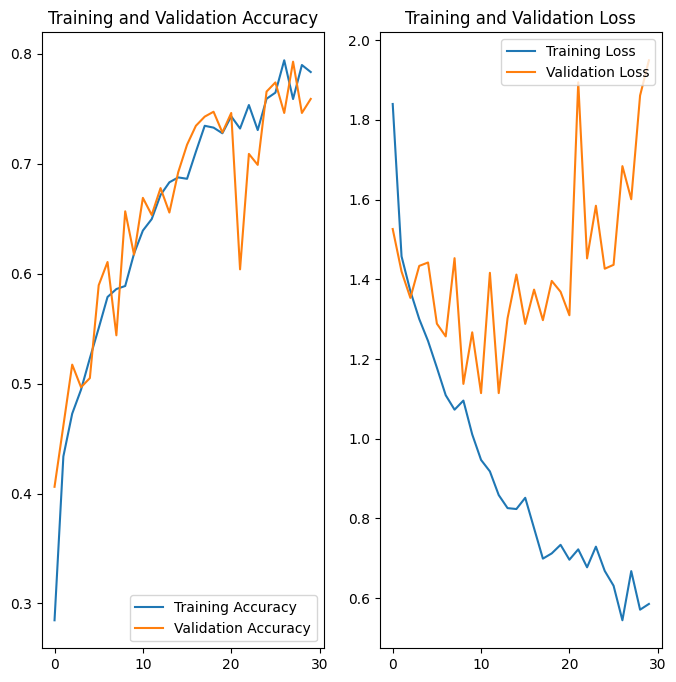

In [144]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### The model accuracy is around 78% and the validation accuracy is around 76 % which shows that there is no overfitting and the acuracy is also decent

#### To improve on accuracy we can train the model with few hyperparmeters like number of epochs 
#### But the assigment explicitely mentions to use only 30 epochs